# Classification multi-classe et jeu mal balancé

Plus il y a de classes, plus la classification est difficile car le nombre d'exemples par classe diminue. Voyons cela plus en détail sur des jeux artificiels produits mar [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

In [1]:
%matplotlib inline

Pour aller plus vite, l'apprentissage est un peu écourté. Le code produit beaucoup de warnings indiquant que la convergence n'a pas eu lieu et nécessite plus d'itérations. Cela ne remet pas en cause ce qui est illustré dans ce notebook.

In [2]:
import warnings

warnings.filterwarnings("ignore")

## découverte

Le premier jeu de données est une simple fonction linéaire sur deux variables d'ordre de grandeur différents.

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(2000, cluster_std=2, centers=5)

Text(0.5, 1.0, 'Nuage de point avec 5 classes')

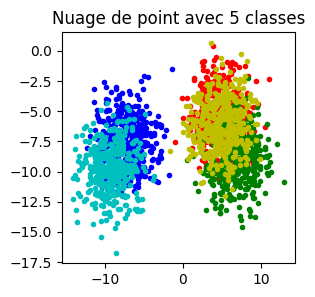

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
for i, c in zip(range(0, 5), "rgbyc"):
    ax.plot(X[y == i, 0], X[y == i, 1], c + ".", label=str(i))
ax.set_title("Nuage de point avec 5 classes")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver="sag")
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
score

0.658

Mettons le jour dans une fonction pour plusieurs modèles :

In [7]:
from time import perf_counter as clock


def evaluate_model(models, X_train, X_test, y_train, y_test):
    res = {}
    for k, v in models.items():
        t1 = clock()
        v.fit(X_train, y_train)
        t2 = clock() - t1
        res[k + "_time_train"] = t2
        t1 = clock()
        score = v.score(X_test, y_test)
        t2 = clock() - t1
        res[k + "_time_test"] = t2
        res[k + "_score"] = score
    return res


from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

models = {
    "OvO-LR": OneVsOneClassifier(LogisticRegression(solver="sag")),
    "OvR-LR": OneVsRestClassifier(LogisticRegression(solver="sag")),
    "LR": LogisticRegression(),
}

res = evaluate_model(models, X_train, X_test, y_train, y_test)
res

{'OvO-LR_time_train': 0.2209448000003249,
 'OvO-LR_time_test': 0.009104000000206725,
 'OvO-LR_score': 0.662,
 'OvR-LR_time_train': 0.2086589999998978,
 'OvR-LR_time_test': 0.005245500000000902,
 'OvR-LR_score': 0.654,
 'LR_time_train': 0.05842000000029657,
 'LR_time_test': 0.0010207000000264088,
 'LR_score': 0.66}

La stratégie *OneVsOne* a l'air d'être plus performante. La régression logistique implémente la stratégie *OneVsRest*. On ne l'évalue plus.

In [8]:
import pandas
from tqdm import tqdm

warnings.filterwarnings("ignore")

models = {
    "OvO-LR": OneVsOneClassifier(LogisticRegression(solver="sag")),
    "OvR-LR": LogisticRegression(solver="sag"),
}

rows = []
for centers in tqdm(range(2, 51, 8)):
    X, y = make_blobs(500, centers=centers, cluster_std=2.0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    res = evaluate_model(models, X_train, X_test, y_train, y_test)
    res["centers"] = centers
    rows.append(res)

df = pandas.DataFrame(rows)
df

100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


,OvO-LR_time_train,OvO-LR_time_test,OvO-LR_score,OvR-LR_time_train,OvR-LR_time_test,OvR-LR_score,centers
0,0.032755,0.001730,1.000,0.022686,0.001637,1.000,2
1,0.324123,0.032629,0.812,0.076139,0.001591,0.808,10
2,0.730089,0.036648,0.488,0.053406,0.000859,0.508,18
3,0.984762,0.096167,0.444,0.116836,0.001022,0.468,26
4,1.537234,0.154609,0.384,0.110220,0.001036,0.388,34
5,2.595010,0.209428,0.328,0.122475,0.000956,0.336,42
6,3.022290,0.437165,0.280,0.150593,0.000868,0.280,50


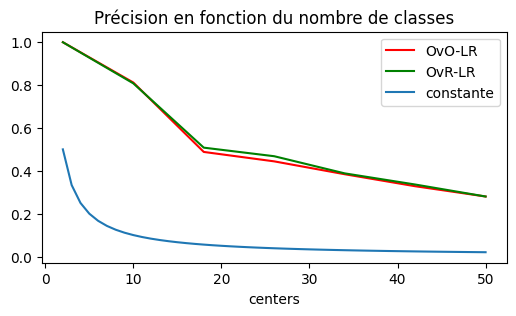

In [9]:
fix, ax = plt.subplots(1, 1, figsize=(6, 3))
for c, col in zip("rgb", [_ for _ in df.columns if "_score" in _]):
    df.plot(x="centers", y=col, label=col.replace("_score", ""), ax=ax, color=c)
x = list(range(2, 51))
ax.plot(x, [1.0 / _ for _ in x], label="constante")
ax.legend()
ax.set_title("Précision en fonction du nombre de classes");

## évolution en fonction du nombre de classes

On pourrait se dire que c'est parce que le nombre d'exemples par classes décroît. Voyons cela.

In [10]:
import pandas

models = {
    "OvO-LR": OneVsOneClassifier(LogisticRegression(solver="sag")),
    "OvR-LR": OneVsRestClassifier(LogisticRegression(solver="sag")),
}

rows = []
for centers in tqdm(range(2, 51, 8)):
    X, y = make_blobs(50 * centers, centers=centers, cluster_std=2.0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    res = evaluate_model(models, X_train, X_test, y_train, y_test)
    res["centers"] = centers
    rows.append(res)

df2 = pandas.DataFrame(rows)
df2

100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


,OvO-LR_time_train,OvO-LR_time_test,OvO-LR_score,OvR-LR_time_train,OvR-LR_time_test,OvR-LR_score,centers
0,0.009756,0.003354,0.980000,0.016191,0.001600,0.980000,2
1,0.248614,0.011291,0.636000,0.092591,0.001695,0.568000,10
2,0.834381,0.067650,0.524444,0.376624,0.004853,0.466667,18
3,1.502573,0.099040,0.460000,0.721085,0.004124,0.436923,26
4,2.613464,0.178248,0.397647,0.990700,0.005284,0.342353,34
5,4.057976,0.297401,0.375238,1.337764,0.006087,0.340952,42
6,6.861960,0.479451,0.316800,2.269823,0.008297,0.269600,50


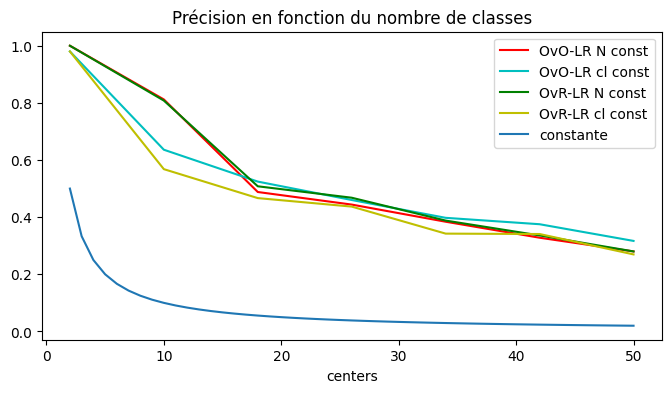

In [11]:
fix, ax = plt.subplots(1, 1, figsize=(8, 4))
for c1, c2, col in zip("rg", "cy", [_ for _ in df2.columns if "_score" in _]):
    df.plot(
        x="centers", y=col, label=col.replace("_score", " N const"), ax=ax, color=c1
    )
    df2.plot(
        x="centers", y=col, label=col.replace("_score", " cl const"), ax=ax, color=c2
    )
x = list(range(2, 51))
ax.plot(x, [1.0 / _ for _ in x], label="constante")
ax.legend()
ax.set_title("Précision en fonction du nombre de classes");

## évolution en fonction de la variance

Un peu mieux mais cela décroît toujours. Peut-être que la courbe dépend de la confusion entre les classes ?

In [12]:
import pandas

models = {
    "OvO-LR": OneVsOneClassifier(LogisticRegression(solver="sag")),
    "OvR-LR": OneVsRestClassifier(LogisticRegression(solver="sag")),
}

rows = []
for std_ in tqdm(range(5, 31, 5)):
    X, y = make_blobs(500, centers=40, cluster_std=std_ / 10.0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    res = evaluate_model(models, X_train, X_test, y_train, y_test)
    res["std"] = std_ / 10.0
    rows.append(res)

df3 = pandas.DataFrame(rows)
df3

100%|██████████| 6/6 [00:16<00:00,  2.78s/it]


,OvO-LR_time_train,OvO-LR_time_test,OvO-LR_score,OvR-LR_time_train,OvR-LR_time_test,OvR-LR_score,std
0,2.031314,0.243204,0.788,0.584626,0.005322,0.560,0.5
1,1.901009,0.275102,0.600,0.527490,0.008637,0.420,1.0
2,1.790364,0.245218,0.496,0.538992,0.005838,0.372,1.5
3,1.985556,0.258749,0.280,0.459469,0.005051,0.228,2.0
4,2.154060,0.258028,0.220,0.603545,0.005316,0.192,2.5
5,2.031245,0.208715,0.200,0.529591,0.005976,0.180,3.0


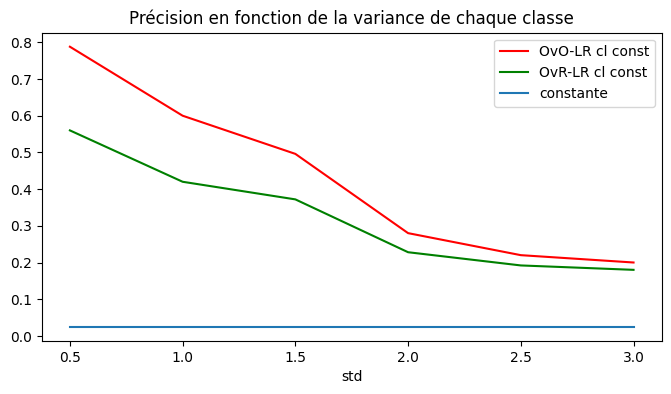

In [13]:
fix, ax = plt.subplots(1, 1, figsize=(8, 4))
for c1, col in zip("rg", [_ for _ in df3.columns if "_score" in _]):
    df3.plot(x="std", y=col, label=col.replace("_score", " cl const"), ax=ax, color=c1)
x = [_ / 10.0 for _ in range(5, 31)]
ax.plot(x, [1 / 40.0 for _ in x], label="constante")
ax.set_title("Précision en fonction de la variance de chaque classe")
ax.legend();

## évolution en fonction de la dimension

Et en fonction du nombre de dimensions :

In [14]:
import pandas

models = {
    "OvO-LR": OneVsOneClassifier(LogisticRegression(solver="sag")),
    "OvR-LR": OneVsRestClassifier(LogisticRegression(solver="sag")),
}

rows = []
for nf in tqdm(range(2, 11, 2)):
    X, y = make_blobs(500, centers=40, cluster_std=2.0, n_features=nf)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    res = evaluate_model(models, X_train, X_test, y_train, y_test)
    res["nf"] = nf
    rows.append(res)

df4 = pandas.DataFrame(rows)
df4

100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


,OvO-LR_time_train,OvO-LR_time_test,OvO-LR_score,OvR-LR_time_train,OvR-LR_time_test,OvR-LR_score,nf
0,2.042428,0.264521,0.320,0.491270,0.005313,0.260,2
1,2.325670,0.225577,0.740,0.760807,0.005378,0.728,4
2,2.953030,0.214104,0.976,0.865434,0.005122,0.952,6
3,2.404396,0.234881,0.996,0.967371,0.009054,0.988,8
4,2.818875,0.287795,1.000,0.898213,0.005280,0.996,10


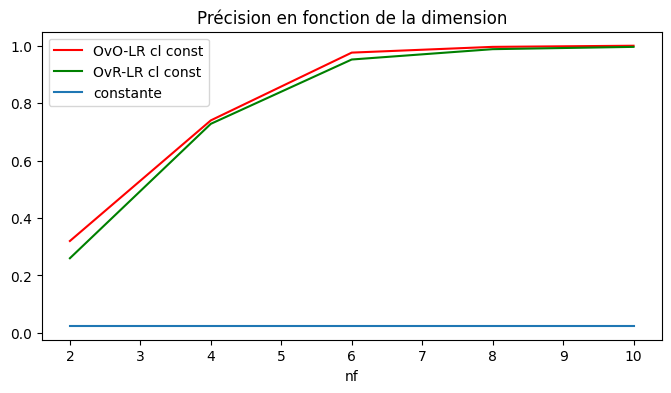

In [15]:
fix, ax = plt.subplots(1, 1, figsize=(8, 4))
for c1, col in zip("rg", [_ for _ in df4.columns if "_score" in _]):
    df4.plot(x="nf", y=col, label=col.replace("_score", " cl const"), ax=ax, color=c1)
x = list(range(2, 11))
ax.plot(x, [1 / 40.0 for _ in x], label="constante")
ax.set_title("Précision en fonction de la dimension")
ax.legend();

## retour sur le nombre de classes

In [22]:
import pandas

models = {
    "OvO-LR": OneVsOneClassifier(LogisticRegression(solver="lbfgs")),
    "OvR-LR": OneVsRestClassifier(LogisticRegression(solver="lbfgs")),
}

rows = []
for centers in tqdm(range(10, 151, 25)):
    X, y = make_blobs(10 * centers, centers=centers, cluster_std=2.0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    res = evaluate_model(models, X_train, X_test, y_train, y_test)
    res["centers"] = centers
    rows.append(res)

df5 = pandas.DataFrame(rows)
df5

100%|██████████| 6/6 [01:45<00:00, 17.58s/it]


,OvO-LR_time_train,OvO-LR_time_test,OvO-LR_score,OvR-LR_time_train,OvR-LR_time_test,OvR-LR_score,centers
0,0.285135,0.017950,0.600000,0.042483,0.002003,0.520000,10
1,2.895627,0.189201,0.302857,0.168547,0.004620,0.251429,35
2,7.890931,0.605583,0.196667,0.367130,0.013213,0.160000,60
3,17.404424,1.189003,0.160000,0.499927,0.012866,0.105882,85
4,26.166851,1.902685,0.132727,0.772086,0.014063,0.083636,110
5,41.347375,2.720673,0.120000,0.901161,0.043177,0.084444,135


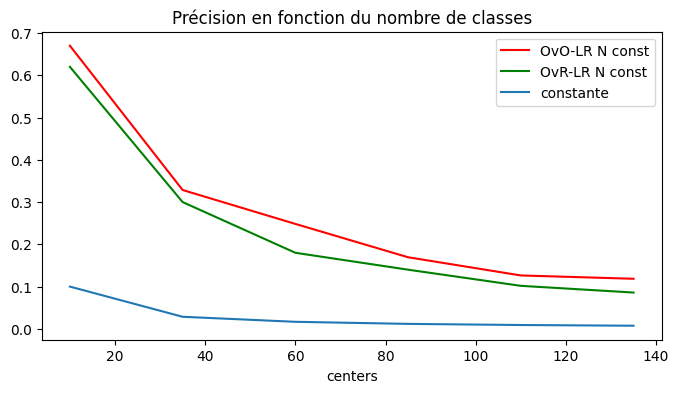

In [17]:
fix, ax = plt.subplots(1, 1, figsize=(8, 4))
for c1, col in zip("rgcy", [_ for _ in df5.columns if "_score" in _]):
    df5.plot(
        x="centers", y=col, label=col.replace("_score", " N const"), ax=ax, color=c1
    )
x = df5.centers
ax.plot(x, [1.0 / _ for _ in x], label="constante")
ax.legend()
ax.set_title("Précision en fonction du nombre de classes");

## un dernier jeu sûr

On construit un dernier jeu pour lequel le taux de classification devrait être 100%.

In [18]:
import numpy


def jeu_x_y(ncl, n):
    uni = numpy.random.random(n * 2).reshape((n, 2))
    resx = []
    resy = []
    for i in range(ncl):
        resx.append(uni + i * 2)
        resy.append(numpy.ones(n) * i)
    X = numpy.vstack(resx)
    y = numpy.hstack(resy)
    return X, y


X, y = jeu_x_y(4, 50)
X.shape, y.shape

((200, 2), (200,))

Text(0.5, 1.0, 'Nuage de point avec 5 classes')

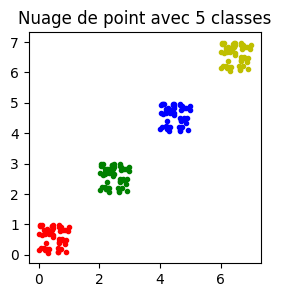

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
for i, c in zip(range(0, 5), "rgbyc"):
    ax.plot(X[y == i, 0], X[y == i, 1], c + ".", label=str(i))
ax.set_title("Nuage de point avec 5 classes")

In [20]:
from sklearn.tree import DecisionTreeClassifier

models = {
    "OvO-LR": OneVsOneClassifier(LogisticRegression(solver="sag")),
    "OvR-LR": OneVsRestClassifier(LogisticRegression(solver="sag")),
    "DT": DecisionTreeClassifier(),
}

rows = []
for centers in tqdm(range(2, 21, 4)):
    X, y = jeu_x_y(centers, 10)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    res = evaluate_model(models, X_train, X_test, y_train, y_test)
    res["centers"] = centers
    rows.append(res)

df5 = pandas.DataFrame(rows)
df5

100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


,OvO-LR_time_train,OvO-LR_time_test,OvO-LR_score,OvR-LR_time_train,OvR-LR_time_test,OvR-LR_score,DT_time_train,DT_time_test,DT_score,centers
0,0.008709,0.003290,1.000000,0.014272,0.002550,1.000000,0.001384,0.001313,1.0,2
1,0.050579,0.007302,0.800000,0.025281,0.002580,0.733333,0.001434,0.001112,1.0,6
2,0.100356,0.013768,0.400000,0.032940,0.001779,0.320000,0.001064,0.000719,1.0,10
3,0.185524,0.020908,0.285714,0.046669,0.001958,0.085714,0.001124,0.000627,1.0,14
4,0.292794,0.039437,0.311111,0.083591,0.003007,0.111111,0.001478,0.000881,1.0,18


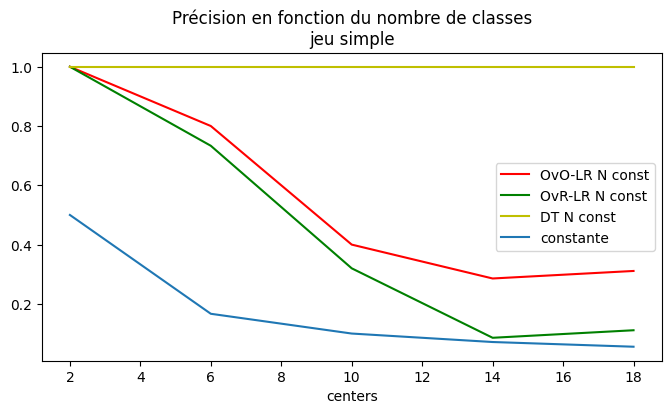

In [21]:
fix, ax = plt.subplots(1, 1, figsize=(8, 4))
for c1, col in zip("rgycbp", [_ for _ in df5.columns if "_score" in _]):
    df5.plot(
        x="centers", y=col, label=col.replace("_score", " N const"), ax=ax, color=c1
    )
x = df5.centers
ax.plot(x, [1.0 / _ for _ in x], label="constante")
ax.legend()
ax.set_title("Précision en fonction du nombre de classes\njeu simple");

La régression logistique n'est pas le meilleur modèle lorsque le nombre de classes est élevé et la dimension de l'espace de variables faible.